In [1]:
import datapackage
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb


%matplotlib inline  

In [2]:
data_url = 'https://datahub.io/machine-learning/bank-marketing/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        df = pd.read_csv(resource.descriptor['path'])

### Brief Exploratory Data Analysis

#### How does our data look?

In [3]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,Class
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,1
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,1


If you want to know what contains any column please go to the Data section in the [wiki](https://github.com/jorgeluisztr/data-intuitions-marketingbank-python/wiki) of the repo 

In [4]:
# I will change the name of the columns just for being clear
keys = df.columns

values = "age,job,marital,education,default,balance,housing,loan,contact,day,month,duration," \
           "campaign,pdays,previous,poutcome,y"
    
namedictionary = dict(zip(keys, values.split(",")))

df = df.rename(columns=namedictionary)

#### Look for missing values

In [5]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

There are no missing values (Lucky guy)

#### Look for data inconsistencies

In [6]:
# Check if the numeric values are ok
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

So far, everything look fine!! (according to the Data section in the [wiki](https://github.com/jorgeluisztr/data-intuitions-marketingbank-python/wiki))


#### What are the unique values in the categorical columns?

In [7]:
for item in df.columns:
    if df[item].dtype == "object":
        print(item)
        print(df[item].unique())
        print("------------")

job
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
------------
marital
['married' 'single' 'divorced']
------------
education
['tertiary' 'secondary' 'unknown' 'primary']
------------
default
['no' 'yes']
------------
housing
['yes' 'no']
------------
loan
['no' 'yes']
------------
contact
['unknown' 'cellular' 'telephone']
------------
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
------------
poutcome
['unknown' 'failure' 'other' 'success']
------------


Everything is what we expected (again, lucky guy!!)

#### Some Graphs

We will graph how some variables of our data are distributed as a didactic exercise. In the processing section we will return to graph but following certain reasonings

Text(0.5,1,'Age Distribution')

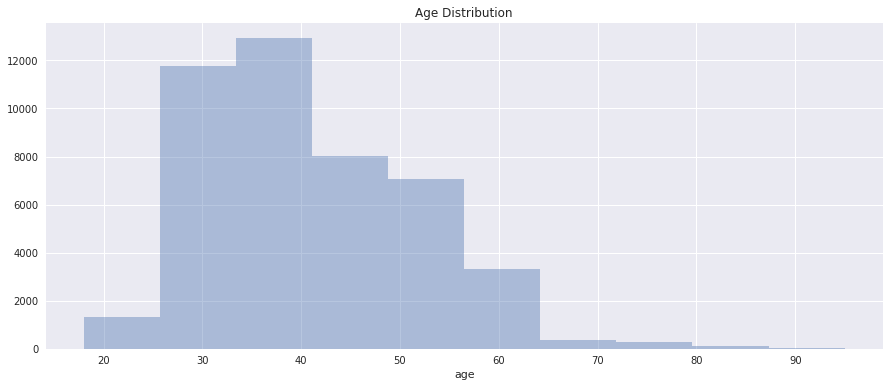

In [8]:
sns.set(rc={'figure.figsize':(15, 6)})
sns.distplot(df.age, bins = 10, kde=False).set_title("Age Distribution")

We can do more interesting things like the following

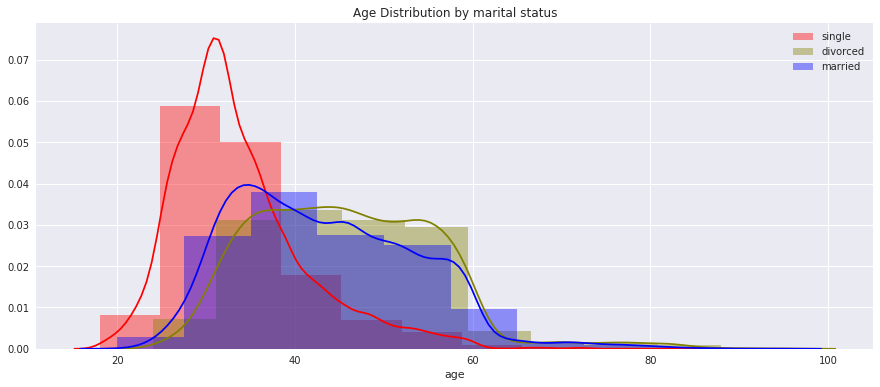

In [9]:
sns.distplot( df[df.marital == "single"].age , bins = 10, color="red", label="single").set_title("Age Distribution"\
                                                                                                " by marital status")
sns.distplot( df[df.marital == "divorced"].age , bins = 10, color="olive", label="divorced")
sns.distplot( df[df.marital == "married"].age , bins = 10, color="blue", label="married").legend()

Now, check a plot of the balance and the age

Text(0.5,1,'Age-Balance')

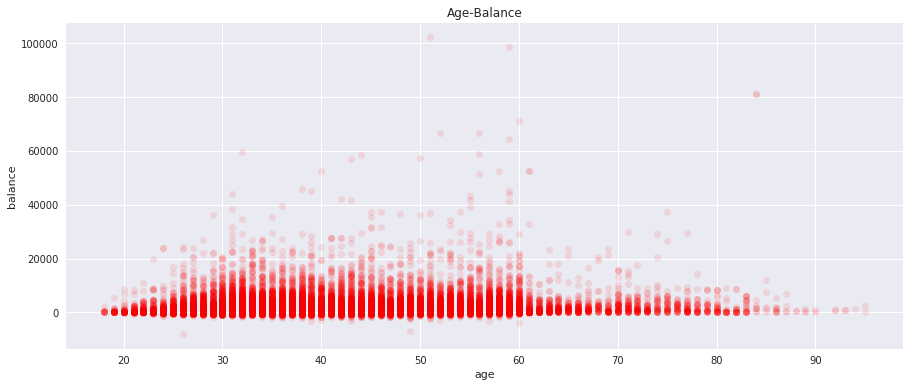

In [10]:
# Plot the responses for different events and regions
sns.regplot(x="age", y="balance", 
            data=df, color="red", 
            scatter_kws={'alpha':0.1},fit_reg=False).set_title("Age-Balance")

#### Balanced data

We will check if the target variable is balanced i.e. there is a relation closed to one-to-one between the two categories.

In [11]:
df.y.value_counts()

1    39922
2     5289
Name: y, dtype: int64

Imagine that for every yes in our objective variable, we have nines no. Any model that always predicts no, will have ninety percent of accuracy. This is not useful for any business, but for our luck there are solutions to solve the problem of unbalanced data (really, lucky guy)

### Processing the data

#### Categorical data

There are some values in some columns that could be not ok as:

* **job:** the value unknown in here is not so problematic because it could be simply other jobs.
* **education:** the value unknown in this column is annoying becausse the level of education could be a signal of income, and that variable is important in the bank market.
* **contact:** the value unknown in here is not a big deal, because it could be simply other contact type.
* **poutcome:** the value unknown in here could be tricky, we have to see if the subject was not exposed to previous campaign.... Also, there is a "other" value that i do not know what it is

#### education's column

The idea is replace the unknown values by assigning them known values based in their probabilities 

In [12]:
# Check the distribution of education
df.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [13]:
# It's time to get your hands dirty and code
myval, mycount = np.unique(df.education.values[df.education != "unknown"],
                          return_counts=1)

df.education.loc[df.education == "unknown"]=np.random.choice(myval, df[df.education == "unknown"].shape[0],
                                                                    p = mycount/mycount.sum())

/home/jorgeluisztr/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
df.education.value_counts()

secondary    24172
tertiary     13878
primary       7161
Name: education, dtype: int64

#### poutcome's column

In [15]:
df.poutcome.value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [16]:
# we will check if there is a relation between not previously exposed client and unknown values for poutcoume
# the answer is yes
df[df.pdays == -1].poutcome.value_counts()

unknown    36954
Name: poutcome, dtype: int64

In [17]:
# As we thought, it is not an unknown value is simply a not previously exposed client (almost, just to be exact)
# But, what does other value mean??
# I will check if the distribution of other not affected to y target

print("-------------- y target is yes--------------------")
print(df[df.y == 2].poutcome.value_counts())
print("-------------- y target is no--------------------")
print(df[df.y == 1].poutcome.value_counts())

-------------- y target is yes--------------------
unknown    3386
success     978
failure     618
other       307
Name: poutcome, dtype: int64
-------------- y target is no--------------------
unknown    33573
failure     4283
other       1533
success      533
Name: poutcome, dtype: int64


I will not drop the "other" values because it seems to have a positive effect on the target variable

#### numerical variables

Remember the graph of balance and age, looks like something that we expected. So, I won't change them

Text(0.5,1,'Day Distribution')

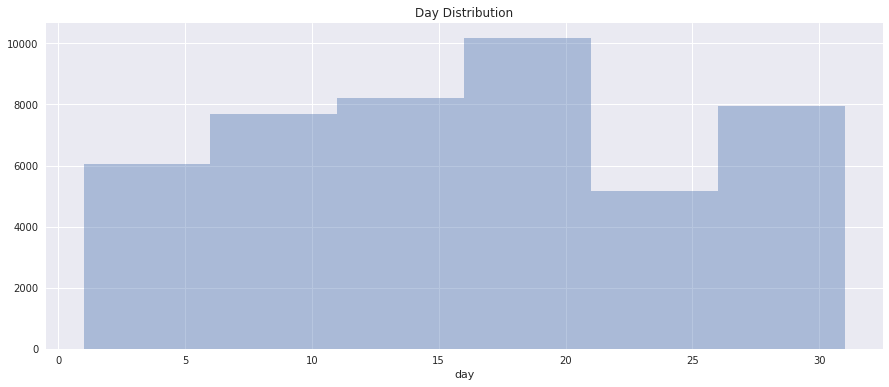

In [18]:
# now, it is time for the distribution of day

sns.distplot(df.day, bins = 6, kde=False).set_title("Day Distribution")

day looks ok i.e. there is no outliers

Text(0.5,1,'Duration Distribution')

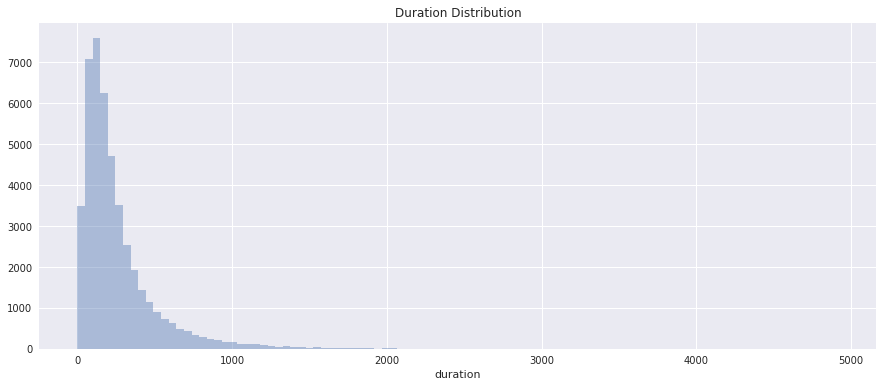

In [19]:
# now, duration of calls

sns.distplot(df.duration, bins = 100, kde=False ).set_title("Duration Distribution")

In [20]:
# duration looks very skewed, also look that long calls are not so frequent. So, we can truncate them (by the righ side)
treshold = 1200 # more than 20 minutes
df.duration = np.where(df.duration > treshold, treshold, df.duration)


Text(0.5,1,'Campaign Distribution')

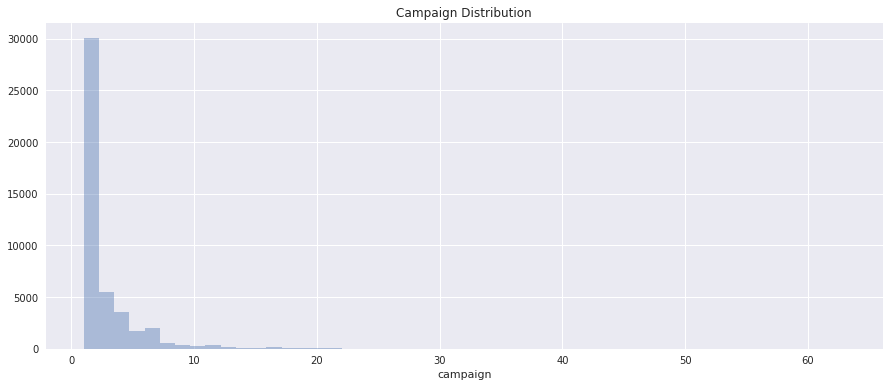

In [21]:
sns.distplot(df.campaign, bins = 50, kde=False).set_title("Campaign Distribution")

In [22]:
# again, just truncate
treshold = 30 # more than 30 calls (aprox. one per day)
df.campaign = np.where(df.campaign > treshold, treshold, df.campaign)

Text(0.5,1,'Pdays Distribution')

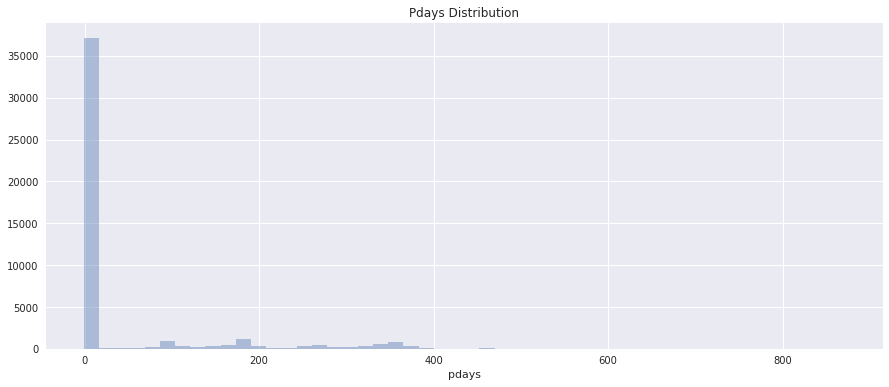

In [23]:
# look the distribution for pdays

sns.distplot(df.pdays, bins = 50, kde=False).set_title("Pdays Distribution")

We have the problem with the -1 values.


I will follow the next strategy:

* Replace -1 with nan values.
* Standardize the pdays values.
* Replace p-values based in a normal distribution with mean 0 and std 1.


In [24]:
# replace -1 by assigning them nan values
# we will do the rest later

df.pdays = np.where(df.pdays == -1, np.nan, df.pdays)
df[df.pdays.isnull()].head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,NaN,0,unknown,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,NaN,0,unknown,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,NaN,0,unknown,1
3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,92,1,NaN,0,unknown,1
4,33,unknown,single,tertiary,no,1,no,no,unknown,5,may,198,1,NaN,0,unknown,1


Text(0.5,1,'Previous Distribution')

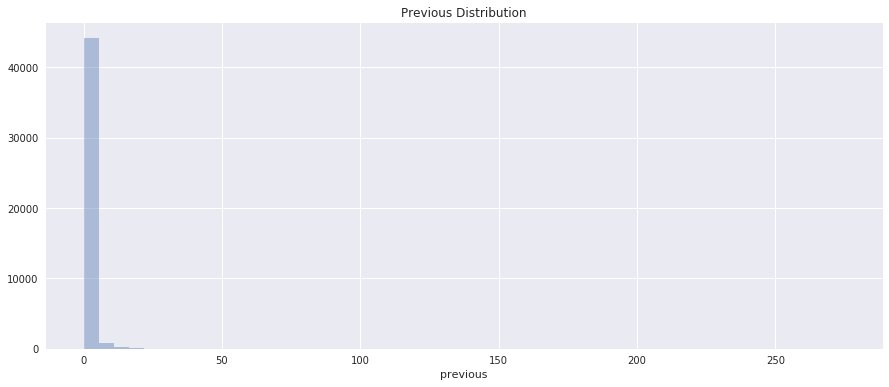

In [25]:
# finally, we have to check the distribution of the "previous" variable

sns.distplot(df.previous, bins = 50,kde = False).set_title("Previous Distribution")

In [26]:
# This looks very problematic but look if there is a perfect reltion between pdays -1 and previous 0
df[df.previous == 0].pdays.unique()

array([nan])

In [27]:
# We have the same proble as before so we will follow the same estrategy
df.previous = np.where(df.previous == 0, np.nan, df.previous)
df[df.previous.isnull()].head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,NaN,NaN,unknown,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,NaN,NaN,unknown,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,NaN,NaN,unknown,1
3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,92,1,NaN,NaN,unknown,1
4,33,unknown,single,tertiary,no,1,no,no,unknown,5,may,198,1,NaN,NaN,unknown,1


### Now we are ready to prepare the data 

#### Split the data in training and testing sets 

In [28]:
# i will use the 20 % of the data for testing
testsize = int(df.shape[0]*.2)

# transform target in zeros and ones
df.y = df.y.map({1:0, 2:1})

# data is highly inbalanced
inbalance_rate = np.round(df[df.y == 0].shape[0]/ df[df.y == 1].shape[0])

# create the partitions
test = np.random.choice(np.asanyarray(df.index), replace=False,size=testsize)
train = df[~df.index.isin(test)]
test = df[df.index.isin(test)]

#### Standardized Numerical data. Notice that i will not use StandardScaler from sklearn, instead of that i will create the functions to do it (properly)

In [29]:
# Creating dictionaries of the means and stds

meandictionary = {}
stddictionary = {}

numcol = "age,balance,day,duration,campaign,pdays,previous"

for item in numcol.split(","):
    meandictionary[item] = train[item].mean()
    stddictionary[item] = train[item].mean()
    
# IMPORTANT MESSAGE: sometimes these types of info are important for future works, so you could save them as pickle files

# Function to standardize the numerical columns 
def standardize(adf, ameandict, astddict, alistwithcols):
    
    for item in alistwithcols:
        adf[item] = (adf[item] - ameandict[item])/astddict[item]
    
    return(adf)
    
# Now standized both training and testing
train = standardize(train, meandictionary, stddictionary, numcol.split(","))
test = standardize(test, meandictionary, stddictionary, numcol.split(","))

#remember that we had problems with pdays and previous values... well now we could solve them
def fixnanvalues(adf, alistwithcols):
    for item in alistwithcols:
        alist = []
        for values in adf[item]:
            if str(values) == "nan":
                alist.append(np.random.normal(0,1,1)[0])
            else:
                alist.append(values)
        adf[item] = alist
    return(adf)

train = fixnanvalues(train, ["pdays", "previous"])
test = fixnanvalues(test, ["pdays", "previous"])

/home/jorgeluisztr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jorgeluisztr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Create conditional distribution variables for training (for this example I will use just marital and education info)

In [30]:
feature = []
aditional =[]
conditional = [["marital"], ["education"], ["marital", "education"]]

for cond in conditional:

    newCol = 'conditional_'
    for variable in cond:
        newCol = newCol + variable + '_'
                
    tmp = train.groupby(cond)['y'].agg({newCol + 'prob': np.mean, newCol + 'count': "count"}).reset_index()
    
    
    train = train.merge(tmp, on=cond, how="left")

/home/jorgeluisztr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


#### I have to be very careful how I do the merge with the test data (errors in here could be very disastrous)

In [31]:
selectcols = ["marital", "education"]
for item in train.columns:
    if "conditional" in item:
        selectcols.append(item)
        
dfjustconditionalinfo = train[selectcols].drop_duplicates()
test = test.merge(dfjustconditionalinfo, on = ["marital", "education"], how="left")

#### Transform Categorical Data

In [32]:
def genericfunctioncategorical(adf, adictwithcolumns, binarylist):
    catlist = []
    for item in adictwithcolumns:
        catlist.append(pd.get_dummies(adf[item]).drop(adictwithcolumns[item], axis = 1))
        adf = adf.drop(item, axis = 1)
        
    for bina in binarylist:
        adf[bina] = adf[bina].map({'yes':1, 'no':0})
    
    catdf = pd.concat(catlist, axis=1)
    return(pd.concat([adf, catdf], axis = 1))

dictcols = {"education": "tertiary", "job": "unknown", "marital":"single", "contact":"unknown",
           "month": "jan", "poutcome":"unknown"}

listcols = ['default', 'housing', 'loan']

train = genericfunctioncategorical(train, dictcols, listcols)
test = genericfunctioncategorical(test, dictcols, listcols)

### Now is time for Machine Learning

In [33]:
## Columns we will need
colofint = []

for item in train.columns:
    if item != 'y':
        colofint.append(item)
        
## I do in this way because sometimes we will need this variable for future works and we could save them as pickle files

## Declare our variables
y_train = np.asanyarray(train.y, dtype=int)
y_test = np.asanyarray(test.y, dtype=int)

X_train= train[colofint]
X_test = test[colofint]

#### Lightgbm for classification

In [34]:
# lightgbm model

print('Start training...')
# train
gbm = lgb.LGBMClassifier(objective='binary',
                          num_leaves=30,
                          boosting = 'dart',
                          lambdal2=0.5,
                          learning_rate=.1,
                          n_estimators=60,
                          scale_pos_weight = inbalance_rate)

gbm.fit(X_train, y_train,
        eval_metric='logloss')

y_hat = gbm.predict(X_test)

Start training...


/home/jorgeluisztr/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Results

I will show the false and true, both negative and positive in terms of ratios. For me it is more illustrative to see it in this form

In [35]:
countpos = 0
countneg = 0
for i in range(len(y_test)):
    if y_test[i] == 1:
        countpos = countpos + np.absolute(y_test[i] - y_hat[i])
    
    else:
        countneg = countneg + np.absolute(y_test[i] - y_hat[i])
        
FP = countpos/y_test.sum()
TP = 1 - countpos/y_test.sum()
FN = countneg/(len(y_test) - y_test.sum())
TN = 1 - countneg/(len(y_test) - y_test.sum())

print("False Positives:", FP)
print("True Positives: ", TP)
print("False Negatives:", FN)
print("True Negatives: ", TN)
print("Accuracy:       ", (len(y_test) - countpos - countneg)/len(y_test))

False Positives: 0.10412757973733583
True Positives:  0.8958724202626642
False Negatives: 0.17740722166499498
True Negatives:  0.822592778335005
Accuracy:        0.8312320283123202


* **True Positives: ** Accuracy of the model to predict when a client will suscribe a term deposit

* **True Negatives: ** Accuracy of the model to predict when a client will not suscribe a term deposit

**With this information a company could design a very reliable targeted campaign for its clients.**

### Final notes


* **Lightgbm: ** Is a boosting decision tree algorithm that is very fast to create the partitions on the leafs, [here](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf) is a paper that explains how it works.


* **Dart: ** is an algorithm very similar to dropout but for additive trees, [here](http://proceedings.mlr.press/v38/korlakaivinayak15.pdf) is a very good illustatrive paper.


* **Regularization Parameter (l1 in this example): ** Are penalization parameters that allow us to reduce variance in our predictions.